Fetching map data...
Processing features...
Creating visualization...


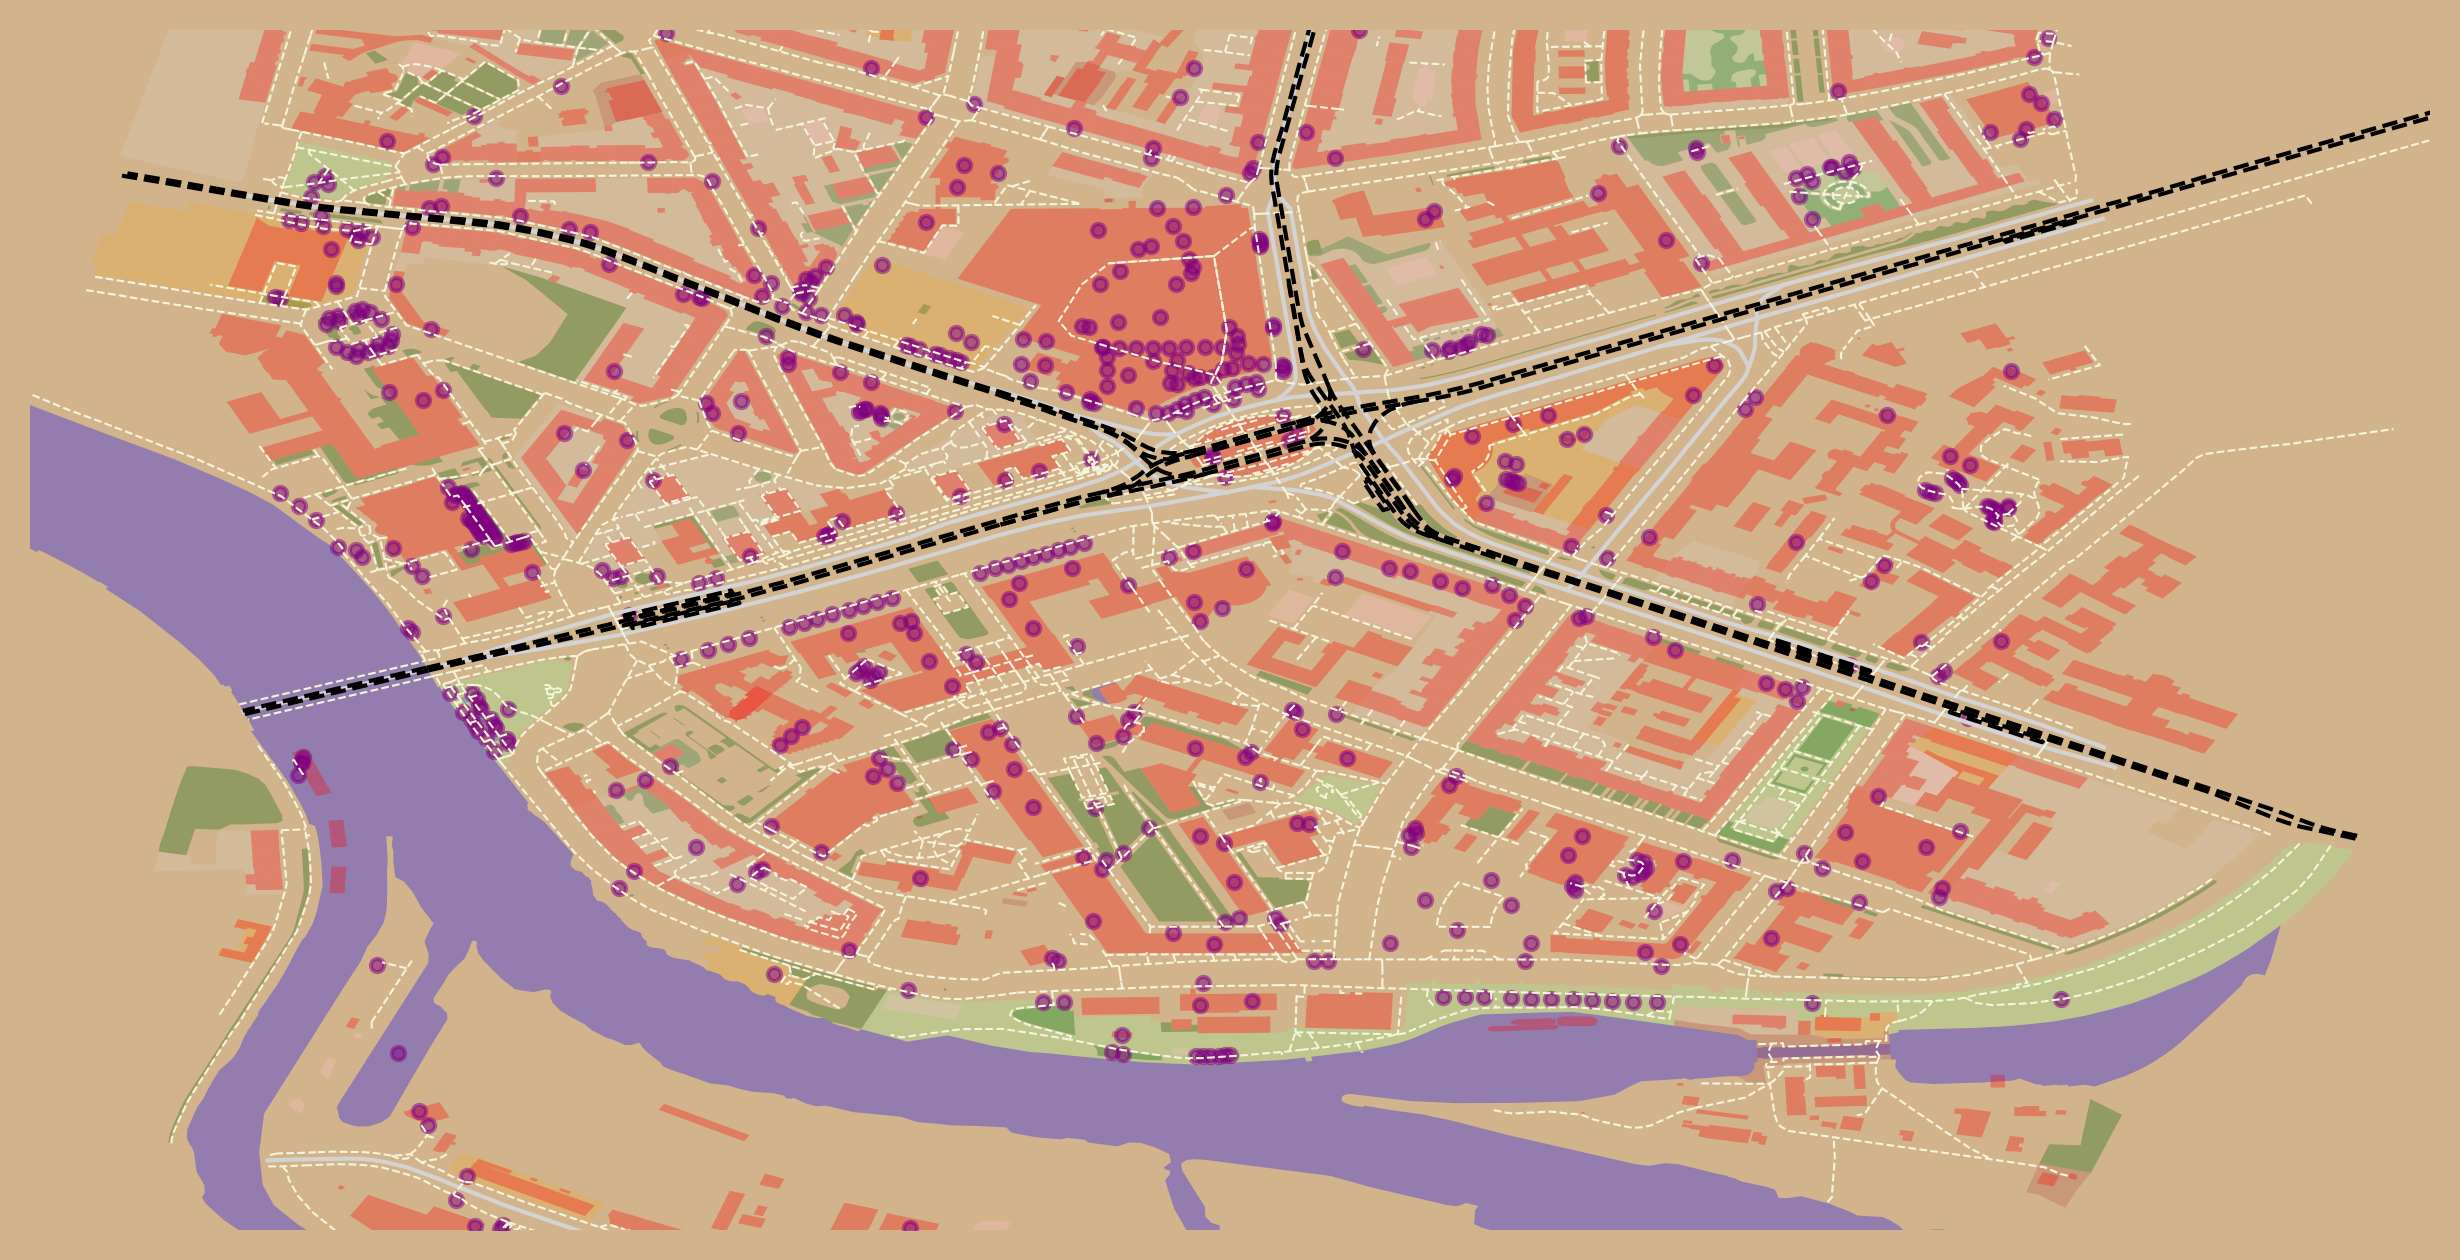

In [1]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.colors as mcolors

class OSMMapGenerator:
    def __init__(self):
        self.overpass_url = "http://overpass-api.de/api/interpreter"
        
    def fetch_map_data(self, south, west, north, east):
        query = f"""
        [out:json][timeout:25];
        (
            // Water features
            way["natural"="water"]({south},{west},{north},{east});
            relation["natural"="water"]({south},{west},{north},{east});
            
            // Green and natural areas
            way["leisure"="park"]({south},{west},{north},{east});
            way["landuse"="grass"]({south},{west},{north},{east});
            way["landuse"="forest"]({south},{west},{north},{east});
            way["landuse"="farmland"]({south},{west},{north},{east});
            way["natural"="scrub"]({south},{west},{north},{east});
            way["natural"="grassland"]({south},{west},{north},{east});
            
            // All roads
            way["highway"]({south},{west},{north},{east});
            
            // Buildings and structures
            way["building"]({south},{west},{north},{east});
            
            // Points of interest
            node["amenity"]({south},{west},{north},{east});
            
            // Railway
            way["railway"]({south},{west},{north},{east});
            
            // Leisure facilities
            way["leisure"]({south},{west},{north},{east});
            
            // Commercial areas
            way["landuse"="commercial"]({south},{west},{north},{east});
            
            // Industrial areas
            way["landuse"="industrial"]({south},{west},{north},{east});
            
            // Residential areas
            way["landuse"="residential"]({south},{west},{north},{east});
        );
        out body;
        >;
        out skel qt;
        """
        
        response = requests.get(self.overpass_url, params={'data': query})
        return response.json()

    def process_data(self, data):
        nodes = {node['id']: (node['lon'], node['lat']) 
                for node in data['elements'] if node['type'] == 'node'}
        
        features = {
            'water': [],
            'green': [],
            'forest': [],
            'farmland': [],
            'residential': [],
            'commercial': [],
            'industrial': [],
            'main_roads': [],
            'secondary_roads': [],
            'pedestrian': [],
            'buildings': [],
            'railway': [],
            'leisure': [],
            'amenities': []
        }
        
        for element in data['elements']:
            if element['type'] == 'way' and 'nodes' in element:
                coords = [nodes[node_id] for node_id in element['nodes']]
                if len(coords) < 2:
                    continue
                
                if 'tags' in element:
                    tags = element['tags']
                    
                    if tags.get('natural') == 'water':
                        features['water'].append(coords)
                    
                    elif tags.get('landuse') in ['grass', 'forest']:
                        features['forest'].append(coords)
                    elif tags.get('leisure') == 'park':
                        features['green'].append(coords)
                    elif tags.get('landuse') == 'farmland':
                        features['farmland'].append(coords)
                    
                    elif 'highway' in tags:
                        if tags['highway'] in ['motorway', 'trunk', 'primary']:
                            features['main_roads'].append(coords)
                        elif tags['highway'] in ['secondary', 'tertiary']:
                            features['secondary_roads'].append(coords)
                        elif tags['highway'] in ['pedestrian', 'footway', 'path']:
                            features['pedestrian'].append(coords)
                    
                    elif 'building' in tags:
                        features['buildings'].append(coords)
                    
                    elif 'railway' in tags:
                        features['railway'].append(coords)
                    
                    elif tags.get('landuse') == 'residential':
                        features['residential'].append(coords)
                    elif tags.get('landuse') == 'commercial':
                        features['commercial'].append(coords)
                    elif tags.get('landuse') == 'industrial':
                        features['industrial'].append(coords)
                    
                    elif 'leisure' in tags:
                        features['leisure'].append(coords)
                        
            elif element['type'] == 'node' and 'tags' in element and 'amenity' in element['tags']:
                features['amenities'].append((element['lon'], element['lat']))
        
        return features

    def plot_map(self, features):
        """Create a detailed visualization of the map features"""
        dpi = 300
        fig = plt.figure(figsize=(8, 8), dpi=dpi, facecolor='tan')
        ax = fig.add_subplot(111)
        
        # Color scheme remains the same...
        colors = {
            'water': ('blue', 0.3),
            'green': ('lightgreen', 0.3),
            'forest': ('darkgreen', 0.3),
            'farmland': ('yellowgreen', 0.2),
            'residential': ('lightgray', 0.2),
            'commercial': ('orange', 0.2),
            'industrial': ('brown', 0.2),
            'buildings': ('red', 0.3),
            'leisure': ('pink', 0.3)
        }

        # Initialize bounds with the exact coordinates you provided
        min_lon, max_lon = 17.0500, 17.0700
        min_lat, max_lat = 51.1050, 51.1150
        
        # Plot features (same as before)...
        for feature_type, (color, alpha) in colors.items():
            if feature_type in features and features[feature_type]:
                for coords in features[feature_type]:
                    if len(coords) >= 3:
                        poly = Polygon(coords, facecolor=color, alpha=alpha, edgecolor='none')
                        ax.add_patch(poly)
        
        # Plot linear features (same as before)...
        if features['main_roads']:
            for coords in features['main_roads']:
                coords_array = np.array(coords)
                ax.plot(coords_array[:, 0], coords_array[:, 1], color='gray', linewidth=2)
        
        if features['secondary_roads']:
            for coords in features['secondary_roads']:
                coords_array = np.array(coords)
                ax.plot(coords_array[:, 0], coords_array[:, 1], color='lightgray', linewidth=1)
        
        if features['pedestrian']:
            for coords in features['pedestrian']:
                coords_array = np.array(coords)
                ax.plot(coords_array[:, 0], coords_array[:, 1], color='beige', linewidth=0.5, linestyle='--')
        
        if features['railway']:
            for coords in features['railway']:
                coords_array = np.array(coords)
                ax.plot(coords_array[:, 0], coords_array[:, 1], color='black', linewidth=1, linestyle='--')
        
        if features['amenities']:
            amenity_coords = np.array(features['amenities'])
            ax.scatter(amenity_coords[:, 0], amenity_coords[:, 1], c='purple', s=10, alpha=0.5)

        # Set exact bounds from the coordinates you provided
        ax.set_xlim(min_lon, max_lon)
        ax.set_ylim(min_lat, max_lat)
        
        # Ensure aspect ratio is equal (square plot)
        ax.set_aspect('equal')
        plt.axis('off')
        
        # Remove padding
        plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)
        
        return fig


# Your specific coordinates
south, west = 51.1050, 17.0520
north, east = 51.1150, 17.0670

generator = OSMMapGenerator()

print("Fetching map data...")
data = generator.fetch_map_data(south, west, north, east)

print("Processing features...")
features = generator.process_data(data)

print("Creating visualization...")
fig = generator.plot_map(features)

plt.show()

# Save the figure with 1024x1024 pixels and 300 DPI
fig.savefig('wroclaw_map_1024.png', 
            dpi=300,
            bbox_inches='tight',
            pad_inches=0)
plt.close()
